### Preliminaries

In [2]:
# Preliminaries to setup the notebook.  
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Import numerical libraries.  
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.model_selection import ShuffleSplit,cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
# Import the file I wrote to load the data from the tab-delimited text files.  
import dream
import loading
import scoring
import fit1

In [4]:
# Load the perceptual descriptors data.  
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
#여기서 training 은 train_set 데이터를 가리킨다. 따라서 perceptual data는 train_set의 데이터값들을 나타낸다. 
loading.format_leaderboard_perceptual_data()
# Show the perceptual metadata types and perceptual descriptor names.
print(perceptual_headers)

['Compound Identifier', 'Odor', 'Replicate', 'Intensity', 'Dilution', 'subject #', 'INTENSITY/STRENGTH', 'VALENCE/PLEASANTNESS', 'BAKERY', 'SWEET', 'FRUIT', 'FISH', 'GARLIC', 'SPICES', 'COLD', 'SOUR', 'BURNT', 'ACID', 'WARM', 'MUSKY', 'SWEATY', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD', 'GRASS', 'FLOWER', 'CHEMICAL']


In [5]:
# Show the metadata and perceptual descriptor values for the first compound.
print(perceptual_obs_data[1])

['126', '4-Hydroxybenzaldehyde', False, 'high', '1/10', '1', 37, 60, 0, 72, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [6]:
num_descriptors = len(perceptual_headers[6:])
#dream.NUM_DESCRIPTORS가 무엇인지 도저히 모르겠다. 알아보자.
#assert는 조건문 으로써 assert다음에 오는 문장이 참이 아님면 밑으로 실행이 되지 않는다. 
assert num_descriptors == dream.NUM_DESCRIPTORS
num_subjects = dream.NUM_SUBJECTS
print('There are %d different perceptual descriptors and %d different subjects' % (num_descriptors,num_subjects))

There are 21 different perceptual descriptors and 49 different subjects


In [7]:
# Load the molecular descriptors data.  
#아래의 코드는 molecular_descriptors_data.txt텍스트를 여는 코드이다. 
molecular_headers, molecular_data = loading.load_molecular_data()
#feature(x)의 개수 4870
#y의 개수 476
print(len(molecular_headers)) 
print(len(molecular_data))
print("First ten molecular descriptor types are %s" % molecular_headers[:10])
print("First ten descriptor values for the first compound are %s" % molecular_data[0][:10])
total_size = len(set([int(row[0]) for row in molecular_data]))
print("We have molecular descriptors for %d unique molecules" % total_size)

4870
476
First ten molecular descriptor types are ['CID', 'complexity from pubmed', 'MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me']
First ten descriptor values for the first compound are ['126', 93.1, 122.13, 8.142, 10.01, 15.305, 10.193, 16.664, 0.667, 1.02]
We have molecular descriptors for 476 unique molecules


In [9]:
#정확하게 len(perceptual_obs_data) 는 총 데이터의 수 
print("There are %d rows in the perceptual data set (at least one for each subject and molecule)" % len(perceptual_obs_data))
print("%d of these are replicates (same subject and molecules)" % sum([x[2] for x in perceptual_obs_data]))

There are 35084 rows in the perceptual data set (at least one for each subject and molecule)
1960 of these are replicates (same subject and molecules)


### Create Molecular Matrix

In [8]:
training_size = len(set([int(row[0]) for row in perceptual_obs_data]))
#perceptual_data에서 하나씩 뽑아와서 row
print(set([int(row[0]) for row in perceptual_obs_data]))
#위의 코드는 len(set([int(row[0]) for row in perceptual_obs_data]))의 결과가 어떻게 되는지 보려고 삽입함. 좀더 알아보자. row[0]이 이해안됨
print(training_size)
#training_size의 크기 보려고 입력함 위에서 처럼 set으로 받으면 중복 없애 주어서 실험용 분자의 개수를 알 수 있다.

print("We have perceptual data for %d unique molecules" % training_size)
remaining_size = total_size - training_size
print ("%d are left out for testing in the competition; half of these (%d) are used for the leaderboard." \
       % (remaining_size,remaining_size/2))

{8193, 6658, 31234, 220674, 1032, 8712, 12297, 12810, 31244, 12813, 31246, 7695, 31249, 85522, 8723, 15380, 31252, 521238, 1049, 7194, 98330, 31260, 31265, 31268, 4133, 12327, 6184, 7720, 9256, 31272, 1068, 9261, 10285, 10797, 444972, 5364729, 7731, 24116, 638014, 21057, 6213, 7749, 60999, 61005, 78925, 7761, 7762, 8785, 7765, 1110, 61527, 7768, 23642, 8797, 6753, 5363388, 61027, 520296, 5362798, 1136, 7795, 62580, 17525, 7799, 7288, 61048, 18554, 7803, 10364, 61052, 126, 11902, 444539, 637563, 10882, 637566, 6276, 24197, 9862, 62087, 440967, 650, 10890, 6287, 7824, 10895, 21648, 5779, 660, 5780, 15510, 101010, 6429333, 8857, 14491, 1183, 10400, 11428, 2214, 7335, 8363, 31404, 7341, 10925, 176, 177, 14514, 3578033, 8375, 8892, 14525, 10430, 15037, 3776, 7360, 7361, 23235, 196, 62144, 2758, 93375, 5280450, 61641, 61130, 18635, 8908, 11980, 10448, 17617, 8914, 61138, 61653, 7894, 8918, 12506, 26331, 61659, 17121, 1549026, 101604, 6374, 61670, 7915, 7916, 643820, 239, 240, 241, 7410, 7921

In [40]:
X_training,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"training")
#dream.make_X해석하기, 특히 assert kind in ['training','leaderboard','testset']이게 뭔지 알기. <-알아서 설명 적어둠
X_training.shape
#if type("training") is str:
    #training = ["training"]
#rint(type(training))
#print("training")
#print(training)

import sys
#sys.stdout = open('결과1/X_training.txt', 'w')
#print(X_training)
sys.stdout = open('결과1/X_training_good1.txt', 'w')
print(good1)
sys.stdout = open('결과1/X_training_good2.txt', 'w')
print(good2)
sys.stdout = open('결과1/X_training_means.txt', 'w')
print(means)
sys.stdout = open('결과1/X_training_stds.txt', 'w')
print(stds)



In [37]:
X_leaderboard_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_other.shape
#print(X_leaderboard_other)

#print(means)

#print(imputer)

sys.stdout = open('결과1/X_leaderboard_other.txt', 'w')
print(X_leaderboard_other)

#일단 이거 살피다가 데이터 전처리 하는것은 넘어가고 빠르게 결과로 가자.

In [39]:
X_leaderboard_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"leaderboard",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_leaderboard_int.shape

X_leaderboard_int
sys.stdout = open('결과1/X_leaderboard_int.txt', 'w')
print(X_leaderboard_int)

In [13]:
X_testset_other,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_testset_other.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [14]:
X_testset_int,good1,good2,means,stds,imputer = dream.make_X(molecular_data,"testset",target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)
X_testset_int.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 69 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (69x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (69x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (69x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (69x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (69x3033) molecules by non-NaN good molecular descriptors


(69, 3033)

In [15]:
X_all,good1,good2,means,stds,imputer = dream.make_X(molecular_data,["training","leaderboard"],good1=good1,good2=good2,means=means,stds=stds)
X_all.shape

Getting CIDs and dilutions...
Getting basic molecular data...
Adding dilution data...
There are now 814 molecular vectors of length 4871, one for each molecule and dilution
Building a matrix...
The X matrix has shape (814x4871) (molecules by molecular descriptors)
Purging data with too many NaNs...
The X matrix has shape (814x4871) (molecules by good molecular descriptors)
Imputing remaining NaN data...
The X matrix now has shape (814x4871) (molecules by non-NaN good molecular descriptors)
Purging data that is still bad, if any...
The X matrix has shape (814x3033) (molecules by good molecular descriptors)
Normalizing data for fitting...
The X matrix now has shape (814x3033) molecules by non-NaN good molecular descriptors


(814, 3033)

In [16]:
Y_training,imputer = dream.make_Y_obs('training',target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [17]:
Y_leaderboard,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (69x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (69x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for eac

In [18]:
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')

Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (676x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (676x42) (molecules by 2 x perceptual descriptors)
Getting basic perceptual data...
Flattening into vectors...
Assembling into matrices...
Y_obs['subject'] contains 49 matrices each with shape (138x21) (molecules by perceptual descriptors)
The Y_obs['mean_std'] matrix has shape (138x42) (molecules by 2 x perceptual descriptors)
Combining Y matrices...
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


### Data preparation

Text(0.5, 0, 'Perceptual descriptor values')

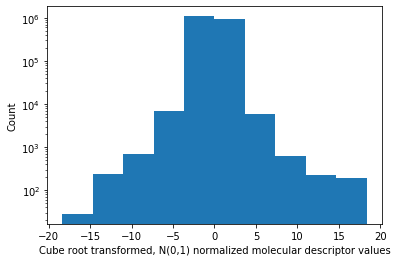

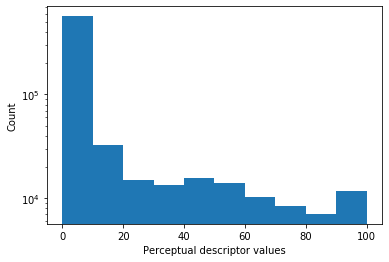

In [19]:
# Show the range of values for the molecular and perceptual descriptors.  
plt.hist(X_training.ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Cube root transformed, N(0,1) normalized molecular descriptor values')
plt.figure()
plt.hist(np.dstack([Y_training['subject'][subject] for subject in range(1,50)]).ravel())
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Perceptual descriptor values')

## Fitting and Generating Submission Files

In [20]:
write = False # Set to True to actually generate the prediction files.  
n_estimators = 5 # Set this to a high number (e.g. 100) to get a good fit.  

# Best parameters, determined independently.  
max_features = {'int':None,
                'ple':100,
                'dec':500}
min_samples_leaf = {'int':1,
                'ple':1,
                'dec':1}
max_depth = {'int':None,
                'ple':10,
                'dec':10}
et = {'int':True,
      'ple':False,
      'dec':False,}

In [41]:
# Fit training data.  
rfcs_leaderboard,score,rs = fit1.rfc_final(X_training,Y_training['subject'],
                            max_features,min_samples_leaf,max_depth,et,
                            n_estimators=n_estimators)


sys.stdout = open('결과1/rfcs_leaderboard.txt', 'w')
print(rfcs_leaderboard)
sys.stdout = open('결과1/rfcs_leaderboard_score.txt', 'w')
print(score)
sys.stdout = open('결과1/rfcs_leaderboard_rs.txt', 'w')
print(rs)

In [22]:
_ = loading.make_prediction_files(rfcs_leaderboard,X_leaderboard_int,X_leaderboard_other,'leaderboard',1,Y_test=Y_leaderboard,write=write)
print(_['subject'][1]) # Print values for subject 1 to make sure it looks right.  

sys.stdout = open('결과1/training result.txt', 'w')
print(_)


Score: 9.856691; rs = 0.434,0.029,0.020
[[67.74       45.53485926 11.38694673 ...  1.3139134   3.64005314
  16.30871753]
 [64.04       47.1324885   1.33120084 ...  2.77306025  4.29559165
  21.32311689]
 [37.12285714 34.38721598  2.43839143 ...  2.00697227  2.37423025
  11.38369428]
 ...
 [27.21428571 48.51978481  1.66148507 ...  2.81808713  5.63339503
   9.04406456]
 [52.84857143 40.75642332  2.11523345 ...  2.09871171  6.20992644
  15.88222253]
 [46.59142857 46.1390201   2.12696753 ...  3.41152515  6.13856617
  12.15222307]]


In [42]:
rfcs,score,rs = fit1.rfc_final(X_all,Y_all_imp['subject'],
                            max_features,min_samples_leaf,max_depth,et,
                            n_estimators=n_estimators)

sys.stdout = open('결과1/rfcs.txt', 'w')
print(rfcs)
sys.stdout = open('결과1/rfcs_score.txt', 'w')
print(score)
sys.stdout = open('결과1/rfcs_rs.txt', 'w')
print(rs)

In [43]:
_ = loading.make_prediction_files(rfcs,X_testset_int,X_testset_other,'testset',1,write=False)
print(_['subject'][1]) # Print values for subject 1 to make sure it looks right. 

sys.stdout = open('결과1/test result.txt', 'w')
print(_)